# 1. Dataset

In [6]:
import pandas as pd

## 1.1. Cargar el dataset

In [7]:
uri = 'https://raw.githubusercontent.com/maribcs/mgp-bayesian-network-retail/main/data/db_mgp_t1.csv'
df = pd.read_csv(uri, sep=",")
df

,row_num,flag_nuevo,fl_omni,fl_fcom,fl_tienda,flag_tienetarjeta,flag_metodopago,flag_tienepromocion,Genero,NSE,Rango_edad,estado_marital,flag_tiene_hijo,rango_gasto
0,27,1,0,0,1,0,0,0,M,C,26-35 AÑOS,C,1,gasto bajo
1,36,1,0,0,1,0,0,0,F,B,36-45 AÑOS,C,0,gasto alto
2,62,1,0,0,1,1,1,0,F,B,26-35 AÑOS,S,0,gasto medio
3,65,0,0,0,1,0,0,0,M,C,36-45 AÑOS,C,1,gasto bajo
4,99,0,0,0,1,1,0,0,F,B,36-45 AÑOS,S,0,gasto alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990387,989561,0,0,0,1,1,0,0,M,A,26-35 AÑOS,S,0,gasto alto
990388,989578,1,0,0,1,0,0,0,M,C,56 A MÁS,C,0,gasto medio
990389,990094,0,0,0,1,1,1,0,M,B,56 A MÁS,S,0,gasto alto
990390,990174,0,0,0,1,0,0,0,F,A,36-45 AÑOS,C,0,gasto bajo


## 1.2. Prepocesar el dataset

In [8]:
# Seleccionar columnas a utilizar
df_modelo = df[['NSE','Rango_edad','Genero','estado_marital','flag_tienetarjeta','flag_nuevo','flag_metodopago','flag_tienepromocion','fl_fcom','rango_gasto']]

In [9]:
# Renombrar columnas

# 1. NSE: Nivel socioeconómico
# 2. E: Edad
# 3. G: Género
# 4. EC: Estado civil
# 5. TR: Tiene o no tarjeta del retail
# 6. TC: Tipo de cliente
# 7. MP: Método de pago
# 8. PP: Producto en promoción o no
# 9. CC: Canal de compra tienda / web
# 10. C: Compra

df_modelo.rename(columns = {'Rango_edad':'E','Genero':'G','estado_marital':'EC','flag_tienetarjeta':'TR','flag_nuevo':'TC','flag_metodopago':'MP','flag_tienepromocion':'PP','fl_fcom':'CC','rango_gasto':'C'}, inplace = True)
df_modelo.head()

<ipython-input-9-228b14a4bd5a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo.rename(columns = {'Rango_edad':'E','Genero':'G','estado_marital':'EC','flag_tienetarjeta':'TR','flag_nuevo':'TC','flag_metodopago':'MP','flag_tienepromocion':'PP','fl_fcom':'CC','rango_gasto':'C'}, inplace = True)


,NSE,E,G,EC,TR,TC,MP,PP,CC,C
0,C,26-35 AÑOS,M,C,0,1,0,0,0,gasto bajo
1,B,36-45 AÑOS,F,C,0,1,0,0,0,gasto alto
2,B,26-35 AÑOS,F,S,1,1,1,0,0,gasto medio
3,C,36-45 AÑOS,M,C,0,0,0,0,0,gasto bajo
4,B,36-45 AÑOS,F,S,1,0,0,0,0,gasto alto


# 2. Modelo

In [10]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.1 MB/s eta 0:00:00


In [12]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator

import networkx as nx
import matplotlib.pyplot as plt

## 2.1. Definición de nodos

In [13]:
model = BayesianNetwork([('NSE', 'TR'), ('TR', 'MP'), ('MP', 'PP'), ('CC', 'PP'),('PP', 'C'),('CC', 'C'),('E', 'TC'),('G', 'TC'),('EC', 'TC'),('TC', 'C')])

## 2.2. DAG del modelo

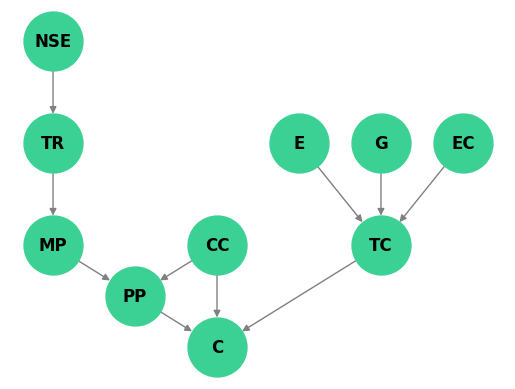

In [14]:
pos = {'NSE': (1, 1), 'TR': (1, 0), 'MP': (1, -1), 'PP': (1.5, -1.5), 'CC': (2, -1), 'E': (2.5, 0),'G': (3, 0),'EC': (3.5, 0),'TC': (3, -1),'C': (2, -2)}

nx.draw_networkx(model, pos=pos, with_labels=True, node_color='#3cd194',
                 node_size=1800, font_size=12, font_weight='bold', edge_color='gray')

plt.axis('off')
plt.show()

## 2.3. Aprendizaje de parámetros

In [15]:
pe = ParameterEstimator(model, df_modelo)

### 2.3.1. Frecuencia de estados

In [16]:
# 1. NSE: Nivel socioeconómico (Incondicional)
print(pe.state_counts('NSE'))

      NSE
A  180269
B  447575
C  295641
D   55556
E   11351


In [17]:
# 2. E: Edad (Incondicional)
print(pe.state_counts('E'))

                 E
16-25 AÑOS    8247
26-35 AÑOS  261838
36-45 AÑOS  320229
46-55 AÑOS  227152
56 A MÁS    172926


In [18]:
# 3. G: Género (Incondicional)
print(pe.state_counts('G'))

        G
F  592960
M  397432


In [19]:
# 4. EC: Estado civil (Incondicional)
print(pe.state_counts('EC'))

       EC
C  409070
S  581322


In [20]:
# 5. TR: Tiene o no tarjeta del retail (Condicional)
print(pe.state_counts('TR'))

NSE       A       B       C      D     E
TR                                      
0     72371  172164  126285  27136  5990
1    107898  275411  169356  28420  5361


In [21]:
# 6. TC: Tipo de cliente (Condicional)
print(pe.state_counts('TC'))

E  16-25 AÑOS                 26-35 AÑOS                     36-45 AÑOS  \
EC          C         S                C            S                 C   
G           F   M     F     M          F     M      F      M          F   
TC                                                                        
0          23   6  3307  1984      10922  4496  95850  63538      45386   
1          25  12  1455  1435       6327  3322  38635  38748      24353   

E                       46-55 AÑOS                      56 A MÁS         \
EC             S                 C             S               C          
G       M      F      M          F      M      F      M        F      M   
TC                                                                        
0   26081  77219  54271      52733  30547  34674  17180    48474  22021   
1   19178  36967  36774      29704  25799  21603  14912    32713  26948   

E                
EC      S        
G       F     M  
TC               
0   18050  4524  
1   1454

In [22]:
# 7. MP: Método de pago (Condicional)
print(pe.state_counts('MP'))

TR       0       1
MP                
0   377676  288425
1    26270  298021


In [23]:
# 8. PP: Producto en promoción o no (Condicional)
print(pe.state_counts('PP'))

CC       0              1       
MP       0       1      0      1
PP                              
0   580214  199949  73406  78375
1     8744   28316   3737  17651


In [24]:
# 9. CC: Canal de compra tienda / web (Incondicional)
print(pe.state_counts('CC'))

       CC
0  817223
1  173169


In [25]:
# 10. C: Compra (Condicional)
print(pe.state_counts('C'))

CC                0                           1                    
PP                0              1            0             1      
TC                0       1      0     1      0      1      0     1
C                                                                  
gasto alto   133439   56630  14172  2131  68243  14578  14560  1126
gasto bajo   206831  210555   8149  3773  27691  12711   2058   552
gasto medio  104249   68459   6968  1867  22244   6314   2682   410


### 2.3.1. Maxima Verosimilitud

In [26]:
mle = MaximumLikelihoodEstimator(model, df_modelo)

In [27]:
# 1. NSE: Nivel socioeconómico
print(mle.estimate_cpd('NSE'))

+--------+-----------+
| NSE(A) | 0.182018  |
+--------+-----------+
| NSE(B) | 0.451917  |
+--------+-----------+
| NSE(C) | 0.298509  |
+--------+-----------+
| NSE(D) | 0.056095  |
+--------+-----------+
| NSE(E) | 0.0114611 |
+--------+-----------+


In [28]:
# 2. E: Edad
print(mle.estimate_cpd('E'))

+---------------+------------+
| E(16-25 AÑOS) | 0.00832701 |
+---------------+------------+
| E(26-35 AÑOS) | 0.264378   |
+---------------+------------+
| E(36-45 AÑOS) | 0.323336   |
+---------------+------------+
| E(46-55 AÑOS) | 0.229356   |
+---------------+------------+
| E(56 A MÁS)   | 0.174604   |
+---------------+------------+


In [29]:
# 3. G: Género
print(mle.estimate_cpd('G'))

+------+----------+
| G(F) | 0.598712 |
+------+----------+
| G(M) | 0.401288 |
+------+----------+


In [30]:
# 4. EC: Estado civil
print(mle.estimate_cpd('EC'))

+-------+----------+
| EC(C) | 0.413038 |
+-------+----------+
| EC(S) | 0.586962 |
+-------+----------+


In [31]:
# 5. TR: Tiene o no tarjeta del retail
cpd_tr = mle.estimate_cpd('TR')
print(cpd_tr)

+-------+---------------------+-----+---------------------+
| NSE   | NSE(A)              | ... | NSE(E)              |
+-------+---------------------+-----+---------------------+
| TR(0) | 0.40146114972624247 | ... | 0.5277068099726896  |
+-------+---------------------+-----+---------------------+
| TR(1) | 0.5985388502737575  | ... | 0.47229319002731035 |
+-------+---------------------+-----+---------------------+


In [32]:
for i in range(0, len(cpd_tr.values)):
  for j in range(0, len(cpd_tr.values[i])):
    print('tr_',i,'nse_',j,': ',cpd_tr.values[i][j])

tr_ 0 nse_ 0 :  0.40146114972624247
tr_ 0 nse_ 1 :  0.3846595542646484
tr_ 0 nse_ 2 :  0.4271565851827047
tr_ 0 nse_ 3 :  0.48844409244726045
tr_ 0 nse_ 4 :  0.5277068099726896
tr_ 1 nse_ 0 :  0.5985388502737575
tr_ 1 nse_ 1 :  0.6153404457353516
tr_ 1 nse_ 2 :  0.5728434148172953
tr_ 1 nse_ 3 :  0.5115559075527396
tr_ 1 nse_ 4 :  0.47229319002731035


In [33]:
# 6. TC: Tipo de cliente (Condicional)
cpd_tc = mle.estimate_cpd('TC')
print(cpd_tc)

+-------+--------------------+-----+--------------------+
| E     | E(16-25 AÑOS)      | ... | E(56 A MÁS)        |
+-------+--------------------+-----+--------------------+
| EC    | EC(C)              | ... | EC(S)              |
+-------+--------------------+-----+--------------------+
| G     | G(F)               | ... | G(M)               |
+-------+--------------------+-----+--------------------+
| TC(0) | 0.4791666666666667 | ... | 0.4444007858546169 |
+-------+--------------------+-----+--------------------+
| TC(1) | 0.5208333333333334 | ... | 0.5555992141453832 |
+-------+--------------------+-----+--------------------+


In [34]:
for i in range(0, len(cpd_tc.values)):
  for j in range(0, len(cpd_tc.values[i])):
    for k in range(0, len(cpd_tc.values[i][j])):
      for l in range(0, len(cpd_tc.values[i][j][k])):
        print('tc_',i,'e_',j,'ec_',k,'g_',l,': ',cpd_tc.values[i][j][k][l])

tc_ 0 e_ 0 ec_ 0 g_ 0 :  0.4791666666666667
tc_ 0 e_ 0 ec_ 0 g_ 1 :  0.3333333333333333
tc_ 0 e_ 0 ec_ 1 g_ 0 :  0.6944561108777825
tc_ 0 e_ 0 ec_ 1 g_ 1 :  0.5802866335185727
tc_ 0 e_ 1 ec_ 0 g_ 0 :  0.6331961273117283
tc_ 0 e_ 1 ec_ 0 g_ 1 :  0.5750831414684062
tc_ 0 e_ 1 ec_ 1 g_ 0 :  0.7127188905825929
tc_ 0 e_ 1 ec_ 1 g_ 1 :  0.6211798291066226
tc_ 0 e_ 2 ec_ 0 g_ 0 :  0.6507979753079338
tc_ 0 e_ 2 ec_ 0 g_ 1 :  0.576261075145275
tc_ 0 e_ 2 ec_ 1 g_ 0 :  0.6762562836074475
tc_ 0 e_ 2 ec_ 1 g_ 1 :  0.5960898456807073
tc_ 0 e_ 3 ec_ 0 g_ 0 :  0.639676358916506
tc_ 0 e_ 3 ec_ 0 g_ 1 :  0.5421325382458382
tc_ 0 e_ 3 ec_ 1 g_ 0 :  0.6161309238232315
tc_ 0 e_ 3 ec_ 1 g_ 1 :  0.5353359092608749
tc_ 0 e_ 4 ec_ 0 g_ 0 :  0.5970660327392316
tc_ 0 e_ 4 ec_ 0 g_ 1 :  0.4496926627049766
tc_ 0 e_ 4 ec_ 1 g_ 0 :  0.5538508745013808
tc_ 0 e_ 4 ec_ 1 g_ 1 :  0.4444007858546169
tc_ 1 e_ 0 ec_ 0 g_ 0 :  0.5208333333333334
tc_ 1 e_ 0 ec_ 0 g_ 1 :  0.6666666666666666
tc_ 1 e_ 0 ec_ 1 g_ 0 :  0.3055438

In [35]:
# 7. MP: Método de pago
print(mle.estimate_cpd('MP'))

+-------+---------------------+---------------------+
| TR    | TR(0)               | TR(1)               |
+-------+---------------------+---------------------+
| MP(0) | 0.9349665549355607  | 0.49181851355453016 |
+-------+---------------------+---------------------+
| MP(1) | 0.06503344506443931 | 0.5081814864454698  |
+-------+---------------------+---------------------+


In [36]:
# 8. PP: Producto en promoción o no
cpd_pp = mle.estimate_cpd('PP')
print(cpd_pp)

+-------+----------------------+-----+---------------------+
| CC    | CC(0)                | ... | CC(1)               |
+-------+----------------------+-----+---------------------+
| MP    | MP(0)                | ... | MP(1)               |
+-------+----------------------+-----+---------------------+
| PP(0) | 0.9851534404830226   | ... | 0.8161851998417096  |
+-------+----------------------+-----+---------------------+
| PP(1) | 0.014846559516977442 | ... | 0.18381480015829046 |
+-------+----------------------+-----+---------------------+


In [37]:
for i in range(0, len(cpd_pp.values)):
  for j in range(0, len(cpd_pp.values[i])):
    for k in range(0, len(cpd_pp.values[i][j])):
        print('pp_',i,'cc_',j,'mp_',k,': ',cpd_pp.values[i][j][k])

pp_ 0 cc_ 0 mp_ 0 :  0.9851534404830226
pp_ 0 cc_ 0 mp_ 1 :  0.8759511970735767
pp_ 0 cc_ 1 mp_ 0 :  0.9515574971157461
pp_ 0 cc_ 1 mp_ 1 :  0.8161851998417096
pp_ 1 cc_ 0 mp_ 0 :  0.014846559516977442
pp_ 1 cc_ 0 mp_ 1 :  0.12404880292642323
pp_ 1 cc_ 1 mp_ 0 :  0.04844250288425392
pp_ 1 cc_ 1 mp_ 1 :  0.18381480015829046


In [38]:
# 9. CC: Canal de compra tienda / web
print(mle.estimate_cpd('CC'))

+-------+----------+
| CC(0) | 0.825151 |
+-------+----------+
| CC(1) | 0.174849 |
+-------+----------+


In [39]:
# 10. C: Compra
cpd_c = mle.estimate_cpd('C')
print(cpd_c)

+----------------+-----+---------------------+
| CC             | ... | CC(1)               |
+----------------+-----+---------------------+
| PP             | ... | PP(1)               |
+----------------+-----+---------------------+
| TC             | ... | TC(1)               |
+----------------+-----+---------------------+
| C(gasto alto)  | ... | 0.539272030651341   |
+----------------+-----+---------------------+
| C(gasto bajo)  | ... | 0.26436781609195403 |
+----------------+-----+---------------------+
| C(gasto medio) | ... | 0.19636015325670497 |
+----------------+-----+---------------------+


In [40]:
for i in range(0, len(cpd_c.values)):
  for j in range(0, len(cpd_c.values[i])):
    for k in range(0, len(cpd_c.values[i][j])):
      for l in range(0, len(cpd_c.values[i][j][k])):
        print('c_',i,'cc_',j,'pp_',k,'tc_',l,': ',cpd_c.values[i][j][k][l])

c_ 0 cc_ 0 pp_ 0 tc_ 0 :  0.3001873935647295
c_ 0 cc_ 0 pp_ 0 tc_ 1 :  0.1687204299793829
c_ 0 cc_ 0 pp_ 1 tc_ 0 :  0.4838676636279832
c_ 0 cc_ 0 pp_ 1 tc_ 1 :  0.2742246815081714
c_ 0 cc_ 1 pp_ 0 tc_ 0 :  0.5774594256122121
c_ 0 cc_ 1 pp_ 0 tc_ 1 :  0.4338303127696932
c_ 0 cc_ 1 pp_ 1 tc_ 0 :  0.7544041450777202
c_ 0 cc_ 1 pp_ 1 tc_ 1 :  0.539272030651341
c_ 1 cc_ 0 pp_ 0 tc_ 0 :  0.4652916973177749
c_ 1 cc_ 0 pp_ 0 tc_ 1 :  0.6273164424211367
c_ 1 cc_ 0 pp_ 1 tc_ 0 :  0.2782273208371744
c_ 1 cc_ 0 pp_ 1 tc_ 1 :  0.485523098700296
c_ 1 cc_ 1 pp_ 0 tc_ 0 :  0.23431603174871804
c_ 1 cc_ 1 pp_ 0 tc_ 1 :  0.37826979733952326
c_ 1 cc_ 1 pp_ 1 tc_ 0 :  0.1066321243523316
c_ 1 cc_ 1 pp_ 1 tc_ 1 :  0.26436781609195403
c_ 2 cc_ 0 pp_ 0 tc_ 0 :  0.23452090911749554
c_ 2 cc_ 0 pp_ 0 tc_ 1 :  0.2039631275994804
c_ 2 cc_ 0 pp_ 1 tc_ 0 :  0.23790501553484245
c_ 2 cc_ 0 pp_ 1 tc_ 1 :  0.24025221979153263
c_ 2 cc_ 1 pp_ 0 tc_ 0 :  0.18822454263906988
c_ 2 cc_ 1 pp_ 0 tc_ 1 :  0.18789988989078357
c_ 2